In [26]:
import re
from typing import Callable

import numpy as np
import torch
import torch.nn as nn

In [27]:
def unary_lambda(symbol: str) -> Callable[[str], str]:
    return lambda a: f"({a}){symbol}"


letters = "abcdefghijklmnopqrstuvwxyz"
digits = "0123456789"

quantifiers: set[str] = {"*", "+", "?"}

unary_regex: dict[str, Callable[[str], str]] = {
    **{symbol: unary_lambda(symbol) for symbol in quantifiers},
    **{symbol: unary_lambda(f"{symbol}?") for symbol in quantifiers},  # greedy versions
}
binary_regex: dict[str, Callable[[str, str], str]] = {
    "concat": lambda a, b: a + b,  # concatenation
    "|": lambda a, b: f"{a}|{b}",
}
many_to_one_regex: dict[str, Callable[[list[str]], str]] = {
    "[]": lambda a: "[" + "".join([f"({x})" for x in a]) + "]"  # set
}

specials_regex: set[str] = {
    ".",
    "^",
    "$",
}

operands_regex: set[str] = {
    *specials_regex,
    *[f"\\{s}" for s in specials_regex],
    *letters,
    *letters.upper(),
    *digits,
    *[f"\\{s}" for s in quantifiers],
}


def rpn_to_infix_regex(expression: list):
    global unary_regex, binary_regex, operands_regex, many_to_one_regex
    stack = []

    for token in expression:
        if token in many_to_one_regex:
            stack = [many_to_one_regex[token](list(reversed(stack)))]
            continue

        if token in binary_regex:
            operand2 = stack.pop()
            operand1 = stack.pop()
            stack.append(binary_regex[token](operand1, operand2))
            continue
        if token in unary_regex:
            operand = stack.pop()
            stack.append(f"({token}{operand})")
            continue
        if token in operands_regex:
            stack.append(token)
            continue
        raise RuntimeError(f"Operand '{token}' is unknown")

    return stack[0]

In [28]:
numbers: set[str] = {
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "0",
}

In [29]:
IDX_TO_ACTIONS = {
    (i): action
    for i, action in enumerate(
        set().union(
            # numbers,
            operands_regex,
            set(binary_regex.keys()),
            set(unary_regex.keys()),
            set(many_to_one_regex.keys()),
        )
    )
}
IDX_TO_ACTIONS[len(IDX_TO_ACTIONS)] = "FINISH"
ACTIONS_TO_IDX = {v: k for k, v in IDX_TO_ACTIONS.items()}

ACTIONS = set(ACTIONS_TO_IDX.keys())

In [30]:
IDX_TO_ACTIONS

{0: 'W',
 1: '\\$',
 2: 'P',
 3: 'e',
 4: '\\*',
 5: '8',
 6: '4',
 7: 'x',
 8: 'f',
 9: 'y',
 10: 'R',
 11: 'a',
 12: '\\+',
 13: 'F',
 14: 'L',
 15: '.',
 16: '^',
 17: 'h',
 18: 'u',
 19: '\\?',
 20: 'A',
 21: 'U',
 22: 'X',
 23: 'c',
 24: 'Z',
 25: 'concat',
 26: 'T',
 27: 'J',
 28: '3',
 29: 'l',
 30: '[]',
 31: 'D',
 32: '0',
 33: 'k',
 34: '|',
 35: 'n',
 36: '2',
 37: 'm',
 38: 'w',
 39: 't',
 40: 'b',
 41: 'Q',
 42: 'p',
 43: '1',
 44: 'V',
 45: '$',
 46: 'j',
 47: 'g',
 48: 'N',
 49: '?',
 50: '+',
 51: 'G',
 52: '7',
 53: 'E',
 54: '6',
 55: 'i',
 56: 'M',
 57: 'o',
 58: '\\^',
 59: 'I',
 60: '*',
 61: '\\.',
 62: 's',
 63: 'K',
 64: 'B',
 65: 'r',
 66: 'O',
 67: 'S',
 68: 'Y',
 69: 'C',
 70: 'H',
 71: '5',
 72: 'z',
 73: 'q',
 74: '9',
 75: 'd',
 76: 'v',
 77: 'FINISH'}

In [31]:
HIGHEST = 100

In [ ]:
class Environment:
    penalty = -100
    # penalty = 1
    word_penalty = -10000
    len_penalty = -1

    max_steps = 5

    def __init__(
        self, texts: list[str], targets: list[list[int]], words_counts: list[int]
    ):
        self.texts = texts
        self.targets = targets
        self.words_counts = words_counts
        self.current_index = 0
        self.regexp = None

        self.empty_state_idx = len(ACTIONS_TO_IDX)
        self.finish_action_idx = ACTIONS_TO_IDX["FINISH"]

        self.reset()

    def reset(self):
        self.step_idx = 0
        self.current_index += 1
        if self.current_index >= len(self.words_counts):
            self.current_index = 0
        self.state = [self.empty_state_idx] * self.max_steps
        return self.state

    def get_state(self):
        return self.state

    def get_state_tensor(self):
        return torch.FloatTensor(self.state).unsqueeze(0)

    def reward(self, regexp_actions: list[int]):
        try:
            regex_symbols = [IDX_TO_ACTIONS[x] for x in regexp_actions]
            if regex_symbols[-1] == "FINISH":
                regex_symbols = regex_symbols[: len(regex_symbols) - 1]
            regexp = rpn_to_infix_regex(regex_symbols)
            self.regexp = regexp
            array = [
                x.span() for x in re.finditer(regexp, self.texts[self.current_index])
            ]
        except BaseException:
            return -HIGHEST
            # return 0
        bit_mask = [0 for _ in range(len(self.texts[self.current_index]))]

        for it in array:
            for i in range(it[0], it[1]):
                bit_mask[i] = 1

        return (
            sum(np.bitwise_xor(bit_mask, self.targets[self.current_index])) * self.penalty
        )  # + abs(len(array)-self.words_counts[self.current_index]) * self.word_penalty

    def step(self, action: int) -> tuple[list, float, bool]:
        self.step_idx += 1
        if action == self.finish_action_idx:
            reward = self.reward(self.state[: self.step_idx - 1])
            # self.reset()
            return self.state, reward, True
        if self.step_idx > self.max_steps:  # finish action
            reward = self.reward(self.state[: self.step_idx])
            # self.reset()
            return self.state, reward, True

        self.state[self.step_idx - 1] = action
        return self.state, self.reward(self.state[: self.step_idx]), False

In [33]:
device = torch.device("cpu")  # "cuda" if torch.cuda.is_available() else
len(ACTIONS)
device

device(type='cpu')

In [34]:
ACTIONS

{'$',
 '*',
 '+',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'FINISH',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[]',
 '\\$',
 '\\*',
 '\\+',
 '\\.',
 '\\?',
 '\\^',
 '^',
 'a',
 'b',
 'c',
 'concat',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '|'}

In [35]:
len(ACTIONS)

78

In [36]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [37]:
class PolicyNetwork(nn.Module):
    def __init__(self, observation_space: int, action_space: int, hidden_dim: int = 128):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, hidden_dim)
        self.layer1 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.layer2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, action_space)

    def forward(self, x):
        x = F.leaky_relu(self.input_layer(x))
        x = F.leaky_relu(self.layer1(x))
        x = F.leaky_relu(self.layer2(x))
        actions = self.output_layer(x)
        return F.softmax(actions)

In [38]:
def select_action(policy_network: nn.Module, env: Environment, on_policy=bool):
    state = env.get_state_tensor().to(device)
    action_probs = policy_network(state).squeeze()
    log_probs = torch.log(action_probs)
    cpu_action_probs = action_probs.detach().cpu().numpy()
    if on_policy:
        action = np.argmax(cpu_action_probs)
    else:
        action = np.random.choice(np.arange(len(ACTIONS)), p=cpu_action_probs)

    return action, log_probs, action_probs

In [39]:
policy_network = PolicyNetwork(Environment.max_steps, len(ACTIONS)).to(device)

gamma = 0.99
lr_policy_net = 2**-13
optimizer = torch.optim.Adam(policy_network.parameters(), lr=lr_policy_net)

In [ ]:
train_data = """a2b """
array = [x.span() for x in re.finditer("[1-9]", train_data)]

target = [0 for _ in range(len(train_data))]
for it in array:
    for i in range(it[0], it[1]):
        target[i] = 1

In [41]:
target

[0, 1, 0, 0]

In [42]:
sum(np.bitwise_xor([0, 0, 1, 0], target))

np.int64(2)

In [43]:
env = Environment([train_data], [target], [1])

In [44]:
best_score = -HIGHEST
best_env = env.reset()
NUM_EPISODES = 500
scores = []

In [ ]:
from copy import copy

EVAL_INTERVAL = 500
cache_hits = 0

loop = tqdm(range(NUM_EPISODES))
for episode in loop:
    state = env.reset()
    done = False
    scores.append([-HIGHEST])
    prev_reward = 0
    cumulative_discount = 1.0
    prev_states = [env.get_state()]

    on_policy = (episode + 1) % EVAL_INTERVAL == 0

    loss = 0

    episode_reward = 0
    episode_log_probs = []

    # run episode
    while not done:
        action, actions_log_probabilities, _ = select_action(
            policy_network, env, on_policy
        )
        # print("Action", action, IDX_TO_ACTIONS[action])
        episode_log_probs.append(actions_log_probabilities[action])

        next_state, new_score, done = env.step(action)

        if new_score > best_score:
            best_score = new_score
            best_env = copy(next_state)
            print(
                "Best Action",
                action,
                IDX_TO_ACTIONS[action],
                best_env,
                best_score,
                env.regexp,
            )

        prev_score = scores[episode][-1]

        # reward = round((new_score - prev_score), 2)
        reward = new_score
        episode_reward += reward

        scores[episode].append(new_score)

        if done:
            env.reset()

    if not on_policy:
        num_steps = len(episode_log_probs)
        per_timestep_losses = [
            -log_prob * episode_reward for log_prob in episode_log_probs
        ]
        total_loss = torch.stack(per_timestep_losses).sum()

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    loop.set_postfix({"best": best_score})

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\Kiaver\AppData\Local\Temp\ipykernel_22696\4078418271.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(actions)
100%|██████████| 500/500 [00:02<00:00, 197.14it/s, best=-100]


In [46]:
IDX_TO_ACTIONS[8]

'f'

In [47]:
best_env

[78, 78, 78, 78, 78]

In [48]:
best_score

-100

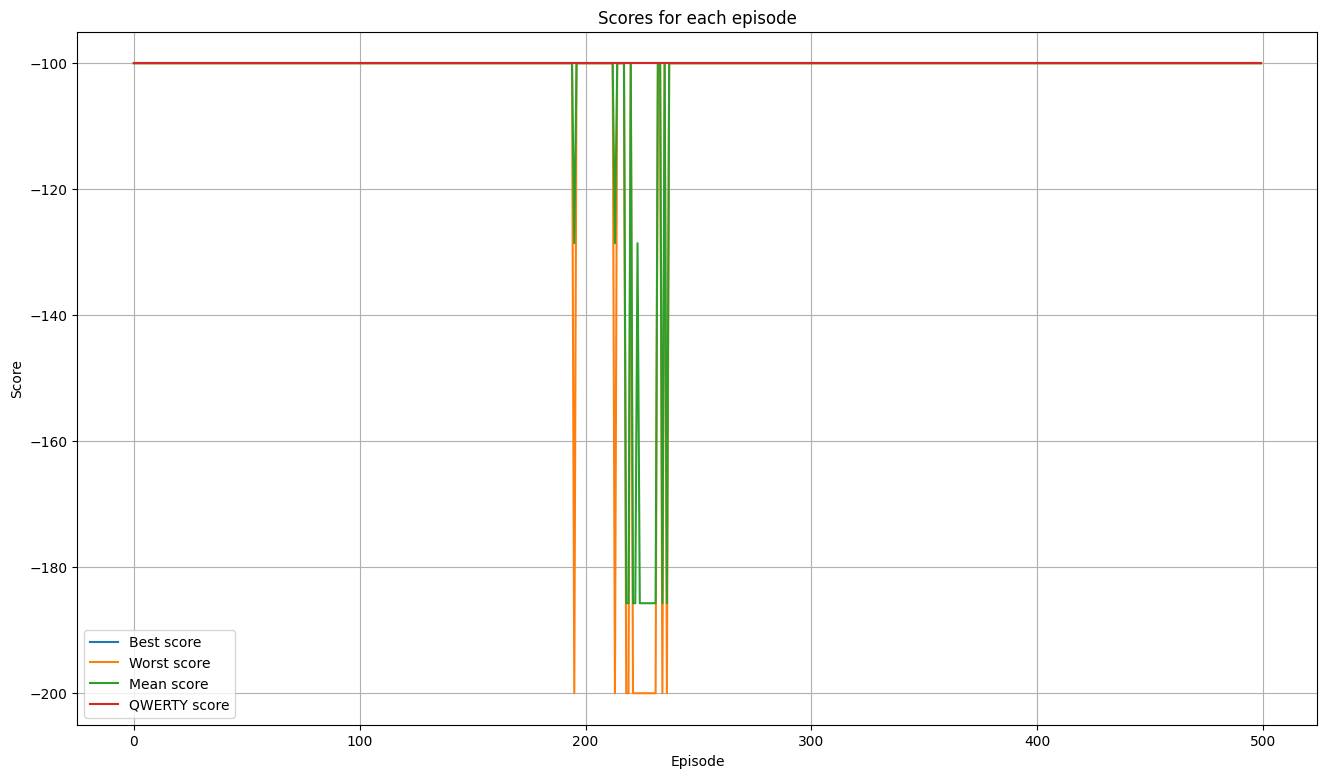

In [ ]:
import matplotlib as mpl


def plot_run(scores: list[float], figsize: tuple[int, int] = (20, 9)):
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    cmap = plt.get_cmap("jet", len(scores))
    for i in range(len(scores)):
        ax1.plot(scores[i], c=cmap(i))
    norm = mpl.colors.Normalize(vmin=0, vmax=len(scores))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.arange(len(scores)), ax=ax1)
    plt.grid()
    plt.show()


def split_scores(scores):
    odd = []
    even = []
    for i in range(len(scores)):
        if (i + 1) % EVAL_INTERVAL == 0:
            odd.append(scores[i])
        else:
            even.append(scores[i])
    return odd, even


def plot_scores(scores: list[float], figsize: tuple[int, int] = (16, 9)):
    best_scores = [max(x) for x in scores]
    worst_scores = [min(x) for x in scores]
    mean_scores = [np.mean(x) for x in scores]
    qwerty_scores = [x[0] for x in scores]

    plt.subplots(1, 1, figsize=figsize)
    plt.plot(best_scores, label="Best score")
    plt.plot(worst_scores, label="Worst score")
    plt.plot(mean_scores, label="Mean score")
    plt.plot(qwerty_scores, label="QWERTY score")

    plt.legend()
    plt.grid()
    # plt.xlim([0, 500])
    # plt.ylim([best_score, 14000])
    plt.ylabel("Score")
    plt.xlabel("Episode")
    plt.title("Scores for each episode")
    plt.show()


plot_scores(scores)